In [2]:
from Bio import Entrez, SeqIO
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML
import time
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from threading import Thread
import queue
from tabulate import tabulate
import re
from collections import Counter

In [ ]:
# email address required to access GenBank
Entrez.email = "megzlives@gmail.com"

In [ ]:
# function to retrieve genomic data
def retrieve_genomic_data(accession):
    print(f"Attempting to retrieve data for {accession}")
    for attempt in range(3):  # Try to fetch the data up to 3 times
        try:
            handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gbwithparts", retmode="text")
            print(f"Downloading data for {accession}...")
            # Use SeqIO.parse() to read multi-sequence GenBank files
            records = list(SeqIO.parse(handle, "genbank"))
            handle.close()
            print(f"Successfully retrieved data for {accession}")
            return records  # This will be a list of records
        except Exception as e:
            print(f"An error occurred while fetching {accession}: {e}")
            print("Attempting to retry...")
            time.sleep(2)  # Wait for 2 seconds before retrying
    print(f"Failed to retrieve data for {accession} after multiple attempts.")
    return None

In [ ]:
# Define a dictionary to hold the accession numbers for each organism and their components
accession_numbers = {
    "Deinococcus radiodurans": ["NZ_CP038663.1", "NZ_CP038664.1", "NZ_CP038666.1", "NZ_CP038665.1"],
    "Thermus thermophilus": ["NC_006461.1", "NC_006463.1", "NC_006462.1"], 
    "Deinococcus deserti": ["NC_012526.1", "NC_012527.1", "NC_012529.1", "NC_012528.1"],
    "Deinococcus proteolyticus": ["NC_015161.1", "NC_015169.1", "NC_015162.1", "NC_015170.1", "NC_015163.1"],
    "Deinococcus geothermalis": ["NC_008025.1", "NC_008010.2", "NC_009939.1"],
    "Thermococcus gammatolerans": ["NC_012804.1"]
}

In [ ]:
# Retrieve genomic data for each organism
all_organism_sequences = {}
for organism, accessions in accession_numbers.items():
    all_organism_sequences[organism] = []
    for accession in accessions:
        records = retrieve_genomic_data(accession)
        if records:
            all_organism_sequences[organism].extend(records)
            print(f"Records for {accession} ({organism}) added to the database.")
        else:
            print(f"Could not retrieve records for {accession} ({organism}).")

In [ ]:
# times out if BLAST search takes too long. time is in seconds 
# change organism to the desired species for the BLAST search
def perform_blast(sequence, database="nt", organism="Thermococcus gammatolerans", timeout=1200):
    def blast_thread(queue, sequence, database, organism):
        try:
            result_handle = NCBIWWW.qblast("blastn", database, sequence, entrez_query=f'organism="{organism}"')
            queue.put(result_handle)
        except Exception as e:
            print(f"Error performing BLAST: {str(e)}")
            queue.put(None)

    q = queue.Queue()
    blast_thread = Thread(target=blast_thread, args=(q, sequence, database, organism))
    blast_thread.start()
    blast_thread.join(timeout)

    if blast_thread.is_alive():
        print("BLAST search timed out")
        return None
    else:
        return q.get()

In [ ]:
# function for extracting gene sequence 
# change search_type to gene to search for gene name or locus_tag to search by locus tag
# change organism to the organism you want to search for target genes in
def extract_gene_sequence(search_term, search_type='locus_tag', organism='Deinococcus radiodurans'):
    with open("gene_and_locus_tags.txt", "w") as file:  # Open a text file for writing
        found = False  # Flag to check if the gene is found
        for record in all_organism_sequences[organism]:
            for feature in record.features:
                if feature.type in ["gene", "CDS"]:
                    # Extract gene name, locus tag, and gene ID
                    gene_name = feature.qualifiers.get("gene", ["No gene name"])[0]
                    locus_tag = feature.qualifiers.get("locus_tag", ["No locus tag"])[0]
                    gene_id_list = feature.qualifiers.get("db_xref", [])
                    gene_id = next((id_part.split(":")[1] for id_part in gene_id_list if id_part.startswith("GeneID:")), "No Gene ID")
                    file.write(f"{gene_name}\t{locus_tag}\t{gene_id}\n")  # Write to file
                    if search_type in feature.qualifiers:
                        # This can be a list, so check if the search term is in the list
                        if search_term in feature.qualifiers[search_type]:
                            print(f"Found {search_type} {search_term} in {organism}, Record ID: {record.id}")
                            found = True
                            gene_sequence = feature.extract(record.seq)
                            return gene_sequence
            if not found:
                print(f"Gene with {search_type} {search_term} not found in record {record.id}.")
    if not found:
        print(f"Search completed. Gene with {search_type} {search_term} not found in any of the GenBank records.")
    return None


In [ ]:
# function to parse BLAST results
def parse_blast_results(blast_result_handle):
    blast_records = NCBIXML.read(blast_result_handle)
    results = []
    for alignment in blast_records.alignments:
        for hsp in alignment.hsps:
            result = {
                'title': alignment.title,
                'score': hsp.score,
                'e_value': hsp.expect,
                'identities': hsp.identities,
                'align_length': hsp.align_length
            }
            results.append(result)
    return results

In [ ]:
# function to display BLAST results
def display_blast_results(blast_results):
    for gene, results in blast_results.items():
        print(f"Results for {gene}:")
        for result in results:
            print(f"Title: {result['title']}")
            print(f"Score: {result['score']}")
            print(f"E-value: {result['e_value']}")
            print(f"Identities: {result['identities']}")
            print(f"Alignment length: {result['align_length']}")
            print("\n")

In [ ]:
# dictionary of target genes in D. radiodurans; includes gene name and locus tags
target_genes = {
    "PprA": "E5E91_RS15025",
    "RecA": "E5E91_RS11810",
    "DdrA": "E5E91_RS02140",
    "DdrB": "E5E91_RS00360",
    "DdrC": "E5E91_RS00015",
    "NADH-quinone oxidoreductase subunit N": "E5E91_RS07520",
    "LigD": None,  # Replace with the actual locus tag when found
    "Dps": "E5E91_RS11440",
    "Bcp": None,   # Replace with the actual locus tag when found
    "IrrE": "E5E91_RS00855",
    "Ssb": None,   # Replace with the actual locus tag when found
    "PolA": "E5E91_RS08585",
    "ThyA": "E5E91_RS13290",
    "PNPase": "E5E91_RS10905"
}

In [ ]:
# dictionary to store BLAST results for each gene
blast_results = {}

In [ ]:
# extract gene sequences based on locus tag
for gene, locus_tag in target_genes.items():
    if locus_tag:  # Make sure the locus tag is not None
        gene_sequence = extract_gene_sequence(locus_tag, search_type='locus_tag')
        if gene_sequence:
            # Placeholder for the code to proceed with BLAST or other processing
            print(f"Gene sequence found for {gene}: {gene_sequence[:10]}...")  # Show part of the gene sequence
        else:
            print(f"Sequence extraction failed for gene: {gene}")
    else:
        print(f"Locus tag not found for gene: {gene}")

In [ ]:
# function for retrying BLAST search if it fails
def retry_blast_for_gene(gene, sequence, organism, database="nt", timeout=1200):
    print(f"Retrying BLAST search for {gene}...")
    result_handle = perform_blast(sequence, database, organism, timeout)
    if result_handle:
        # Parse the BLAST result handle and store it in the blast_results dictionary
        blast_results[gene] = parse_blast_results(result_handle)
        print(f"BLAST search successful for {gene}")
    else:
        print(f"Retrying BLAST search failed for gene: {gene}")

In [ ]:
# Perform BLAST and parse results, with retry for failures
for gene, locus_tag in target_genes.items():
    if locus_tag:
        gene_sequence = extract_gene_sequence(locus_tag, search_type='locus_tag')
        if gene_sequence:
            print(f"Performing BLAST search for {gene}...")
            result_handle = perform_blast(str(gene_sequence), organism="Thermococcus gammatolerans")
            if result_handle:
                blast_results[gene] = parse_blast_results(result_handle)
                print(f"BLAST search completed for {gene}")
            else:
                print(f"BLAST search failed for gene: {gene}, attempting retry...")
                retry_blast_for_gene(gene, str(gene_sequence), "Thermococcus gammatolerans")
        else:
            print(f"Sequence extraction failed for gene: {gene}")
    else:
        print(f"Locus tag not found for gene: {gene}")

In [ ]:
# Function to save BLAST results to a CSV file (IE, there was too much data to just display lol)
def save_blast_results_to_csv(blast_results, file_name):
    rows = []
    for gene, results in blast_results.items():
        for result in results:
            row = {
                'gene': gene,
                'title': result['title'],
                'score': result['score'],
                'e_value': result['e_value'],
                'identities': result['identities'],
                'align_length': result['align_length']
            }
            rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv(file_name, index=False)

# Call the function to save BLAST results
save_blast_results_to_csv(blast_results, "blast_results.csv")

In [4]:
# FILTER BLAST RESULTS
# Load BLAST results
df = pd.read_csv("t_gammatolerans_blast_results.csv")

# Filter based on e-value threshold (e.g., e-value < 0.05)
e_value_threshold = 0.05
df_filtered = df[df['e_value'] < e_value_threshold]

# Save the significant BLAST results to a new CSV file
significant_blast_results_file = "t_gammatolerans_significant_blast_results.csv"
df_filtered.to_csv(significant_blast_results_file, index=False)

print(f"Significant BLAST results saved to {significant_blast_results_file}")

Significant BLAST results saved to t_gammatolerans_significant_blast_results.csv


In [16]:
# TABLE GENERATION 
# Sort the DataFrame by e_value in ascending order (lower e_value is more significant)
df_sorted = df_filtered.sort_values('e_value')

# Select the top N significant results to display
top_n = 10  # Adjust this number as needed
df_top_significant = df_sorted.head(top_n)

# Dictionary of long gene name aliases
gene_aliases = {
    "NADH-quinone oxidoreductase subunit N": "Ku",
    # Add other gene aliases if needed
}

# Replace long gene names with their shorter aliases
df_top_significant['gene'] = df_top_significant['gene'].replace(gene_aliases)

# Set display options for better table formatting
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.precision', 3)  # Set precision for floating point numbers
pd.set_option('display.width', None)  # Auto-detect the display width
pd.set_option('display.colheader_justify', 'center')  # Center-justify column headers

# Limit the length of the 'title' field to make the table more compact
max_title_length = 50  # Adjust this value as needed
df_top_significant['title'] = df_top_significant['title'].apply(lambda x: x[:max_title_length] + '...' if len(x) > max_title_length else x)

# Define the title for the table
table_title = "Top 10 Significant BLAST Results for T. gammatolerans"

# Display the title
print(table_title)
print("-" * len(table_title))  # Optional: underline for the title

# Define columns to display
columns_to_display = ['gene', 'title', 'score', 'e_value', 'identities', 'align_length']

# Format and display the table using 'tabulate'
from tabulate import tabulate
table = tabulate(df_top_significant[columns_to_display], headers='keys', tablefmt='grid')
print(table)

Top 10 Significant BLAST Results for T. gammatolerans
-----------------------------------------------------
+-----+--------+-------------------------------------------------------+---------+-------------+--------------+----------------+
|     | gene   | title                                                 |   score |     e_value |   identities |   align_length |
+=====+========+=======================================================+=========+=============+==============+================+
|  70 | Ku     | gi|239909610|gb|CP001398.1| Thermococcus gammatole... |      48 | 0.000114441 |           30 |             34 |
+-----+--------+-------------------------------------------------------+---------+-------------+--------------+----------------+
| 167 | PNPase | gi|239909610|gb|CP001398.1| Thermococcus gammatole... |      38 | 0.0283984   |           22 |             24 |
+-----+--------+-------------------------------------------------------+---------+-------------+--------------+-------

In [8]:
# ORGANISM CHART
# Load the BLAST results
df = pd.read_csv("t_gammatolerans_significant_blast_results.csv")

# Function to extract species name from the title
def extract_species(title):
    match = re.search(r'\|\s([A-Za-z]+ [a-z]+)', title)
    return match.group(1) if match else 'Unknown'

# Apply the function to extract species names
df['species'] = df['title'].apply(extract_species)

# Count occurrences of each species
species_counts = Counter(df['species'])

# Sort the species by count and format for better readability
sorted_species_counts = sorted(species_counts.items(), key=lambda x: x[1], reverse=True)
formatted_output = "\n".join([f"{species}: {count}" for species, count in sorted_species_counts])

# Display the formatted output
print(formatted_output)

Thermococcus gammatolerans: 4


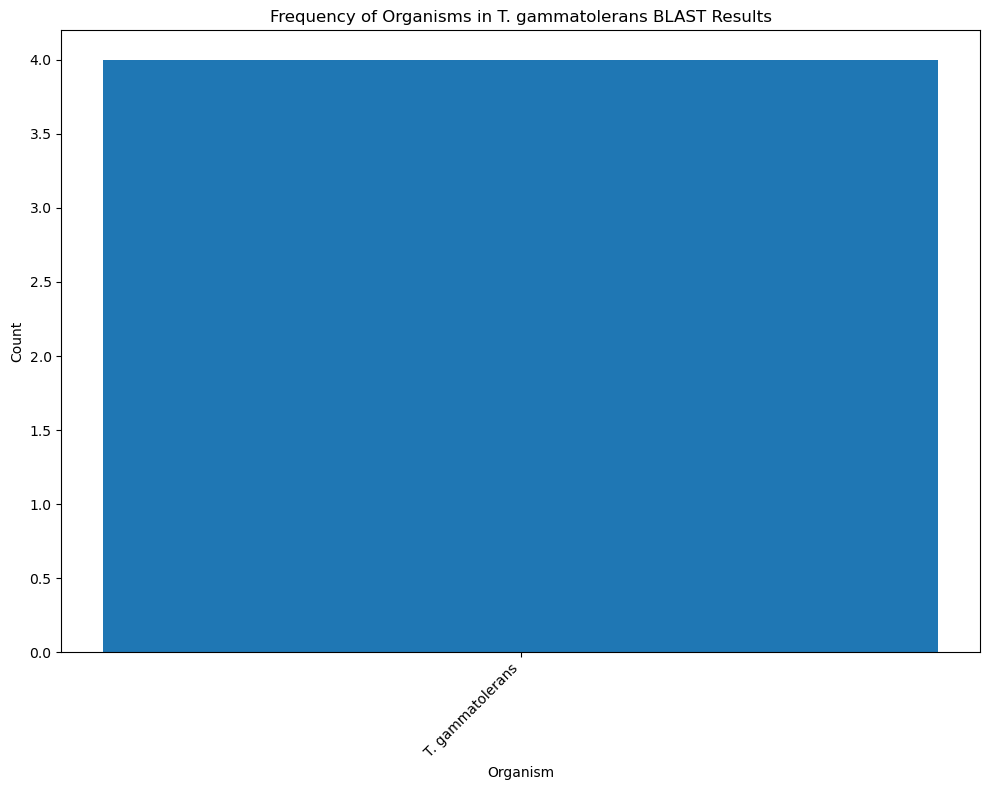

In [10]:
# ORGANISM BAR CHART
# Abbreviate species names
def abbreviate_species(species):
    parts = species.split()
    if len(parts) > 1:
        return f"{parts[0][0]}. {parts[1]}"
    return species

abbreviated_species_counts = {abbreviate_species(species): count for species, count in sorted_species_counts}

# Create the bar chart
plt.figure(figsize=(10, 8))
plt.bar(abbreviated_species_counts.keys(), abbreviated_species_counts.values())

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adding labels and title
plt.title('Frequency of Organisms in T. gammatolerans BLAST Results')
plt.xlabel('Organism')
plt.ylabel('Count')

# Show the plot
plt.tight_layout()
plt.show()

In [11]:
# T-TEST FOR HGT LIKELIHOOD
# Calculate HGT likelihood score
df_filtered['hgt_score'] = (1 / df_filtered['e_value']) * df_filtered['identities']

# Define a threshold for high HGT likelihood
hgt_score_threshold = df_filtered['hgt_score'].quantile(0.75)  # Example: top 25% as HGT candidates

# Group 1: Potential HGT Candidates
hgt_candidates = df_filtered[df_filtered['hgt_score'] >= hgt_score_threshold]

# Group 2: Control Group
control_group = df_filtered[df_filtered['hgt_score'] < hgt_score_threshold]

# Perform t-test on the scores
t_stat, p_val = ttest_ind(hgt_candidates['score'], control_group['score'], nan_policy='omit')
print(f"T-test: t-statistic = {t_stat}, p-value = {p_val}")

T-test: t-statistic = nan, p-value = nan


C:\Users\megzl\AppData\Local\Temp\ipykernel_3448\1974445303.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = ttest_ind(hgt_candidates['score'], control_group['score'], nan_policy='omit')
C:\Users\megzl\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1250: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\megzl\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


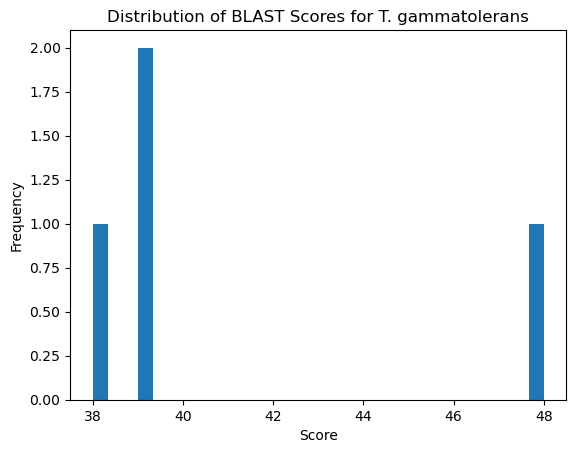

In [13]:
# Histogram of BLAST Scores
plt.hist(df_filtered['score'], bins=30)
plt.title('Distribution of BLAST Scores for T. gammatolerans')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

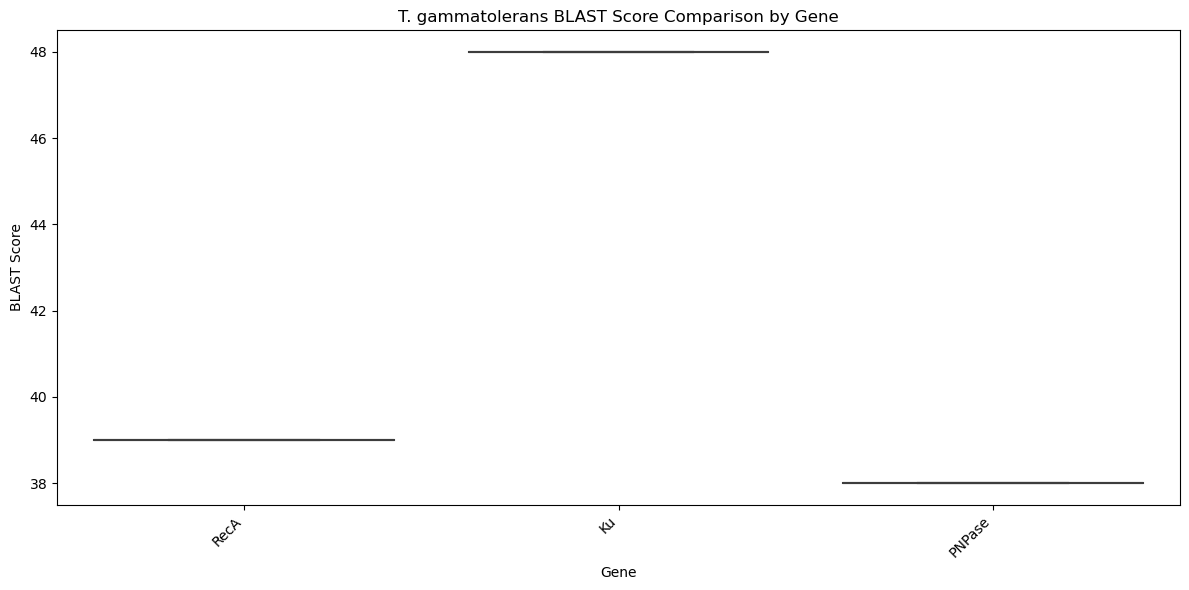

In [15]:
# Copy the filtered DataFrame for plotting
plot_data = df_filtered.copy()

# Replace the long gene name with a shorter alias for the plot
plot_data['gene'] = plot_data['gene'].replace('NADH-quinone oxidoreductase subunit N', 'Ku')

# Increase the size of the plot
plt.figure(figsize=(12, 6))

# Boxplot for Score Comparison
sns.boxplot(x='gene', y='score', data=plot_data)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adding labels and title
plt.title('T. gammatolerans BLAST Score Comparison by Gene')
plt.xlabel('Gene')
plt.ylabel('BLAST Score')

# Show plot
plt.tight_layout()
plt.show()
